In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd

sys.path.append('../lib')
from local_paths import analysis_dir, database_dir, mplstyle_path
from summary_utils import verified_update, annotate_unit_df, select_units, summarize_results_per_region
from stats_utils import get_bootstrap_spread
from plot_utils import annotate_per_region_axes, axis_off_save_labels

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'trial_level_sc'
results_dir = analysis_dir + analysis_name

# analysis-specific conditions
conds = ('Return', 'Same image', 'Distant')
cond_keys = ('return', 'same_im', 'distant')
pal = palettable.cartocolors.qualitative.Bold_10.mpl_colors
cond_palette = dict(zip(conds, (pal[0], 'k', pal[3])))

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'
min_n_per_region = 25

# statistics
spread_type = 'ci_of_mean'

# Load data

In [4]:
bynt_unit_df = {}
bynt_results = {}
bynt_coords = {}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            dur = f[analysis_name+'/mode_dur'][()]
            dset = f[analysis_name+'/self_consistency']
            dset_ = dset['same_im']
        except (KeyError, AssertionError):
            continue

        unit_names = dset['unit'][()].astype(str)
        ts = dset['time'][()]
        nt = ts.size
        if nt not in bynt_results:
            bynt_unit_df[nt] = {'Session': [], 'Unit': []}
            bynt_results[nt] = {k: [] for k in ('self_consistency',)}
            bynt_coords[nt] = {}
        unit_df = bynt_unit_df[nt]
        results = bynt_results[nt]
        coords = bynt_coords[nt]

        verified_update(coords, dict(time=ts, dur=dur))
        results['self_consistency'].append([dset[k][()] for k in cond_keys])

    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

for nt in bynt_unit_df:
    ts = bynt_coords[nt]['time']
    dur = bynt_coords[nt]['dur']
    results = bynt_results[nt]
    unit_df = bynt_unit_df[nt]
    print('presentation duration:', dur, 'ms')
    print(nt, f'timepoints ({ts[0]}--{ts[-1]})')
    print('results:')
    for d in (results, unit_df):
        for k, v in d.items():
            d[k] = v = np.concatenate(v, axis=-1)
            print('', f'{k:<16s}', v.shape, v.dtype, sep='\t')
    print(np.unique(unit_df['Session']).size, 'sessions')
    bynt_unit_df[nt] = annotate_unit_df(pd.DataFrame(unit_df))
    print()

presentation duration: 1500 ms
34 timepoints (-100--1550)
results:
	self_consistency	(3, 34, 42187)	float32
	Session         	(42187,)	<U10
	Unit            	(42187,)	<U4
394 sessions

presentation duration: 3000 ms
64 timepoints (-100--3050)
results:
	self_consistency	(3, 64, 4764)	float32
	Session         	(4764,)	<U8
	Unit            	(4764,)	<U4
55 sessions

presentation duration: 2000 ms
44 timepoints (-100--2050)
results:
	self_consistency	(3, 44, 4662)	float32
	Session         	(4662,)	<U10
	Unit            	(4662,)	<U3
59 sessions

presentation duration: 5000 ms
104 timepoints (-100--5050)
results:
	self_consistency	(3, 104, 1099)	float32
	Session         	(1099,)	<U8
	Unit            	(1099,)	<U3
16 sessions

presentation duration: 2300 ms
50 timepoints (-100--2350)
results:
	self_consistency	(3, 50, 33)	float32
	Session         	(33,)	<U8
	Unit            	(33,)	<U3
1 sessions

presentation duration: 500 ms
14 timepoints (-100--550)
results:
	self_consistency	(3, 14, 665)	flo

# Select units

In [5]:
bynt_result_vals = {
    nt: results['self_consistency']
    for nt, results in bynt_results.items()}
del bynt_results

In [6]:
nt_to_remove = set()
for nt, result_vals in bynt_result_vals.items():
    ts = bynt_coords[nt]['time']
    dur = bynt_coords[nt]['dur']
    m = (ts >= 0) & (ts < dur)
    print('presentation duration:', dur, 'ms')
    print(nt, f'timepoints ({ts[0]}--{ts[-1]})')

    bynt_unit_df[nt], unit_sel, regions = select_units(
        bynt_unit_df[nt],
        selection_path=unit_sel_path,
        select_valid_values=result_vals[:,m,:])
    print()

    if unit_sel.size:
        bynt_result_vals[nt] = result_vals[...,unit_sel]
    else:
        nt_to_remove.add(nt)

for nt in nt_to_remove:
    del bynt_unit_df[nt]
    del bynt_coords[nt]
    del bynt_result_vals[nt]

presentation duration: 1500 ms
34 timepoints (-100--1550)
> Selected units: n = 17339 of 42187 (41.1% of data, 64.3% of selection) based on visually_selective.csv.gz
> Selected units: n = 12780 of 17339 (73.7%) with valid values
> Excluded 1 rare subjects per region:
	                Units  Norm. units
	Region Subject
	CIT    Ot           6     0.026667
  Selected units: n = 12774 of 12780 (100.0%)

presentation duration: 3000 ms
64 timepoints (-100--3050)
> Selected units: n = 2372 of 4764 (49.8% of data, 8.8% of selection) based on visually_selective.csv.gz
> Selected units: n = 449 of 2372 (18.9%) with valid values
> No rare subject to exclude
	 min norm. units per region: Region
	AIT    0.109091
	CIT    0.091503
	V4     1.000000
	Name: Norm. units, dtype: float64

presentation duration: 2000 ms
44 timepoints (-100--2050)
> Selected units: n = 2151 of 4662 (46.1% of data, 8.0% of selection) based on visually_selective.csv.gz
> Selected units: n = 1416 of 2151 (65.8%) with valid valu

In [7]:
for nt, unit_df in bynt_unit_df.items():
    dur = bynt_coords[nt]['dur'] / 1e3
    n = '4c' if dur == 1.5 else f'x3_{dur}'
    unit_df.reset_index()[['Session','Unit']].to_csv(f'unit_sel/fig{n}.csv.gz', index=False)

# Summarize results per region

In [8]:
bynt_summary = {
    nt: summarize_results_per_region(
        unit_df=bynt_unit_df[nt],
        result_vals=result_vals,
        conds=conds,
        spread_type=spread_type)
    for nt, result_vals in bynt_result_vals.items()}

/home/will/Documents/pub/Project Free View Sp22/code_to_publish/final/free_viewing_staging/Summary/../lib/stats_utils.py:42: RuntimeWarning: Mean of empty slice
  stat_last = lambda v: stat_fun(v, axis=-1)
/home/will/Documents/pub/Project Free View Sp22/code_to_publish/final/free_viewing_staging/Summary/../lib/stats_utils.py:41: RuntimeWarning: Mean of empty slice
  stat_first = lambda v: stat_fun(v, axis=0)
/home/will/Documents/pub/Project Free View Sp22/code_to_publish/final/free_viewing_staging/Summary/../lib/stats_utils.py:42: RuntimeWarning: Mean of empty slice
  stat_last = lambda v: stat_fun(v, axis=-1)
/home/will/Documents/pub/Project Free View Sp22/code_to_publish/final/free_viewing_staging/Summary/../lib/stats_utils.py:41: RuntimeWarning: Mean of empty slice
  stat_first = lambda v: stat_fun(v, axis=0)
/home/will/Documents/pub/Project Free View Sp22/code_to_publish/final/free_viewing_staging/Summary/../lib/stats_utils.py:42: RuntimeWarning: Mean of empty slice
  stat_last = l

/home/will/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


center/spread estimate: ci_of_mean


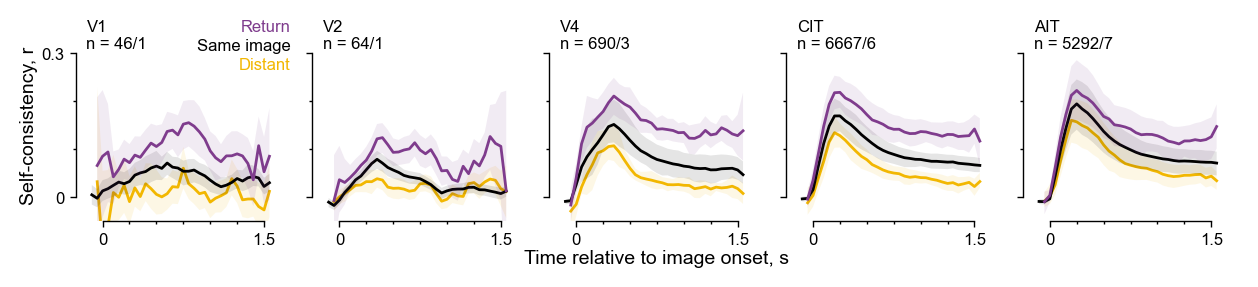

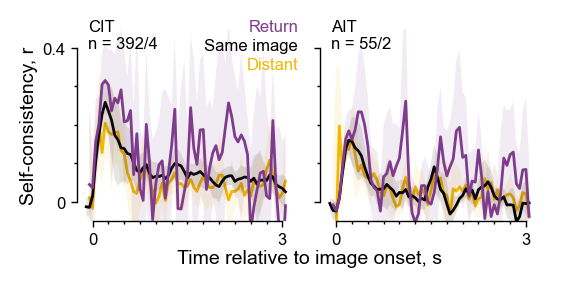

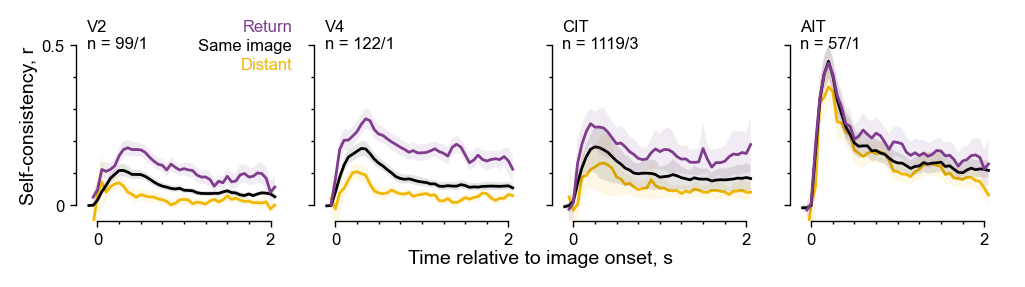

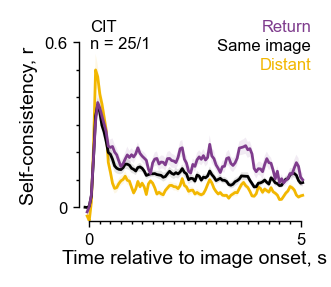

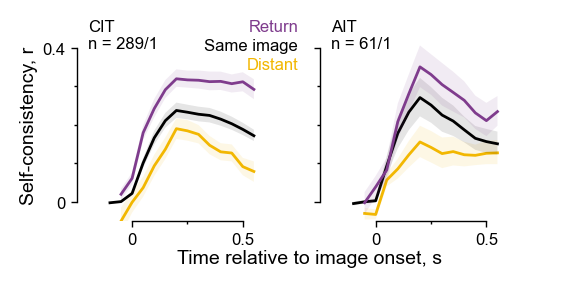

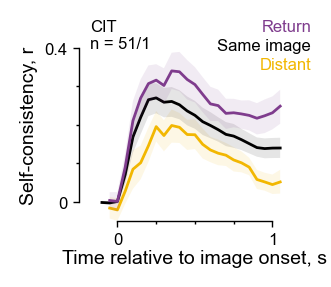

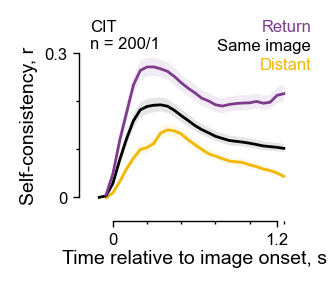

In [9]:
known_regions = ['V1', 'V2', 'V4', 'PIT', 'CIT', 'AIT']
xres = .25
yres = .1

for nt, summary in bynt_summary.items():
    regions_ = sorted(summary['one-level_center_boots'], key=known_regions.index)
    regions = []
    for region in regions_:
        if sum(summary['two-level_nunit'][region].values()) < min_n_per_region:
            continue
        regions.append(region)

    ts = bynt_coords[nt]['time'] / 1e3
    dur = bynt_coords[nt]['dur'] / 1e3
    if not (dur % 1): dur = int(dur)

    ncol = len(regions)
    fig, axs = plt.subplots(
        1, ncol, figsize=(1.5*ncol, 1.25),
        sharex=True, sharey=True, squeeze=False)
    axs = axs.ravel()
    plt.subplots_adjust(wspace=0.1)

    ymax = 0
    for region, ax in zip(regions, axs):
        m, bs = summary['one-level_center_boots'][region]
        for icond, cond in enumerate(conds):
            color = cond_palette[cond]
            ax.plot(ts, m[icond], color=color, zorder=2-icond/10)
            spread = get_bootstrap_spread(m[icond], bs[:,icond], spread_type)
            ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.95-icond/10)
            ymax = max(ymax, np.nanmax(m))

    xbound = (0, dur)
    xlim = (xbound[0]-xres, xbound[1]+xres)
    ymax = round(-(-ymax//yres)*yres, 1)
    ybound = (0, ymax)
    ylim = (ybound[0]-yres/2, ybound[1]+yres/2)
    for region, ax in zip(regions, axs):
        ax.set_xlim(xlim)
        ax.set_xticks(xbound, list(map(str, xbound)))
        ax.set_xticks(np.arange(0, xbound[1]+xres/2, xres), minor=True)
        ax.spines['bottom'].set_bounds(xbound)

        ax.set_ylim(ylim)
        ax.set_yticks(ybound, list(map(str, ybound)))
        ax.set_yticks(np.arange(0, ybound[1]+yres/2, yres), minor=True)
        ax.spines['left'].set_bounds(ybound)

    ax = axs[0]
    ax.set_ylabel('Self-consistency, r')
    tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.yaxis.set_label_coords(-.175, np.mean(ybound), transform=tform)

    ax = fig.add_subplot(111)
    axis_off_save_labels(ax)
    ax.set_xlabel('Time relative to image onset, s', labelpad=10)

    annotate_per_region_axes(
        axs,
        regions,
        ns_per_region=summary['two-level_nunit'],
        conds=conds,
        palette=cond_palette,
        h=1.05,
        r=1)

    if dur == 1.5:
        plt.savefig('plots/fig4c.png')
    else:
        plt.savefig(f'plots/figx3_{dur}.png')

print('center/spread estimate:', spread_type)